**Imports**

In [1117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from dateutil.parser import parse
import random

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

##### Parse Data

In [1118]:
raw_data = pd.read_excel("/Users/marcellszegedi/Documents/Data_Mining/src/datamining/data/simple_data.xlsx")
print(raw_data.head())

              Tijdstempel          What programme are you in?  \
0 2025-04-01 12:17:06.560         MSc Artificial Intelligence   
1 2025-04-01 12:17:14.118            Artificial Intelligence    
2 2025-04-01 12:17:16.917                        Econometrics   
3 2025-04-01 12:17:20.718         Econometrics - Data Science   
4 2025-04-01 12:17:23.836  Bioinformatics’s & Systems Biology   

  Have you taken a course on machine learning?  \
0                                          yes   
1                                          yes   
2                                          yes   
3                                          yes   
4                                          yes   

  Have you taken a course on information retrieval?  \
0                                           unknown   
1                                                 1   
2                                                 1   
3                                                 0   
4                                

##### Rename, drop, convert Columns

In [1119]:
print(raw_data.columns)

Index(['Tijdstempel', 'What programme are you in?',
       'Have you taken a course on machine learning?',
       'Have you taken a course on information retrieval?',
       'Have you taken a course on statistics?',
       'Have you taken a course on databases?', 'What is your gender?',
       'I have used ChatGPT to help me with some of my study assignments ',
       'When is your birthday (date)?',
       'How many students do you estimate there are in the room?',
       'What is your stress level (0-100)?',
       'How many hours per week do you do sports (in whole hours)? ',
       'Give a random number', 'Time you went to bed Yesterday',
       'What makes a good day for you (1)?',
       'What makes a good day for you (2)?'],
      dtype='object')


As we can see the attributes names are phrased as questions, which is improper for the concise analysis, therefore they need to be renamed first.

In [1120]:
raw_data.rename(
    columns={
        "Tijdstempel": "timestamp",
        "What programme are you in?": "programme",
        "Have you taken a course on machine learning?": "experience_ml",
        "Have you taken a course on information retrieval?": "experience_ir",
        "Have you taken a course on statistics?": "experience_st",
        "Have you taken a course on databases?": "experience_db",
        "What is your gender?": "gender",
        "I have used ChatGPT to help me with some of my study assignments ": "chatgpt_usage",
        "When is your birthday (date)?": "birthday",
        "How many students do you estimate there are in the room?": "count_students",
        "What is your stress level (0-100)?": "stress_level",
        "How many hours per week do you do sports (in whole hours)? ": "hours_spend_w_sport",
        "Give a random number": "rnd_number",
        "Time you went to bed Yesterday": "bedtime",
        "What makes a good day for you (1)?": "pleasant_thing_1",
        "What makes a good day for you (2)?": "pleasant_thing_2",
    },
    inplace=True,
)
print(raw_data.columns)

Index(['timestamp', 'programme', 'experience_ml', 'experience_ir',
       'experience_st', 'experience_db', 'gender', 'chatgpt_usage', 'birthday',
       'count_students', 'stress_level', 'hours_spend_w_sport', 'rnd_number',
       'bedtime', 'pleasant_thing_1', 'pleasant_thing_2'],
      dtype='object')


Delete two sample which adds only confusion and zero relevancy to the analysis as based on the their answers they can not be interpreted valid nor responsible.

In [1121]:
print(raw_data.iloc[244])
print(raw_data.iloc[239])

print(len(raw_data.index))
raw_data = raw_data.drop([239, 244])
raw_data = raw_data.reset_index(drop=True)
print(len(raw_data.index))

timestamp                                                                                                                                                                              2025-04-01 12:29:46.856000
programme                                                                                                                                                   B-123456789():;,.?-€/&@„_<|>#,{%^*+=•£$$< \n\+2332‘mm
experience_ml                                                                                                                                                                                             unknown
experience_ir                                                                                                                                                                                                   0
experience_st                                                                                                                                                   

Now that we hve renamed them, and checked the meaning, it is clear that in the (realistic)connection with the target variable (stress level) is variying quite much. Lets drop the one, which should be exclued right away, as their relevancy is not well-established.
The following columns are going to be removed:
- timestamp
- rnd_number

In [1122]:
raw_data.drop(["timestamp", "rnd_number"], axis=1, inplace=True)
print(raw_data.columns)

Index(['programme', 'experience_ml', 'experience_ir', 'experience_st',
       'experience_db', 'gender', 'chatgpt_usage', 'birthday',
       'count_students', 'stress_level', 'hours_spend_w_sport', 'bedtime',
       'pleasant_thing_1', 'pleasant_thing_2'],
      dtype='object')


Now, lets convert the datatypes of the remaining columns that fits their information tpye. First we need to check the boolean valued columns for and correct and discrepancies.
The following columns should have boolean values, (where True means 'yes', False maps to 'no'):
- experience_ml
- experience_ir
- experience_st
- experience_db
- chatgpt_usage

(where True (1) means 'female', False (0) means 'male'):
- gender

Lets check the possible values of the columns listed above:

In [1123]:
for col_name in ["experience_ml", "experience_ir", "experience_st", "experience_db", "gender", "chatgpt_usage"]:
    print(f"{col_name.upper()} values:")
    print(raw_data[col_name].unique())

EXPERIENCE_ML values:
['yes' 'no' 'unknown']
EXPERIENCE_IR values:
['unknown' 1 0]
EXPERIENCE_ST values:
['mu' 'sigma' 'unknown']
EXPERIENCE_DB values:
['ja' 'nee' 'unknown']
GENDER values:
['male' 'female' 'gender fluid' 'not willing to answer' 'intersex'
 'non-binary' 'other']
CHATGPT_USAGE values:
['yes' 'not willing to say' 'no']


Out of the first four columns (experience_..) ml's answers are obvious, while ir's and db's are less but still can be considered well-established as based on the assumed background of the students in the course (who created the dataset), we can expect that they mapped '1' to 'yes' and '0' to 'no' in their answer, and even though 'ja' and 'nee' are in Dutch, their resemblence to their english (or german) correspondance, can be again expected to be correct and reliable.

For the rest three the True (1) and False (0) are going to be mapped to 'yes' and 'no', respectively, while 'unknown' are going to be replaced with 'nan'.

In [1124]:
bin_map_ml = {"yes": True, "no": False}
bin_map_ir = {1: True, 0: False}
bin_map_db = {"ja": True, "nee": False}
bin_map_st = {"mu": True, "sigma": False}

raw_data["experience_ml"] = raw_data["experience_ml"].map(bin_map_ml)
raw_data["experience_ir"] = raw_data["experience_ir"].map(bin_map_ir)
raw_data["experience_db"] = raw_data["experience_db"].map(bin_map_db)
raw_data["experience_st"] = raw_data["experience_st"].map(bin_map_st)

In case of chatgpt_usage we are going to map "yes" to True, "no" to False and leave nan in place of "not willing to say", however for further consideration values of "not willing to say" may be mapped to True.

In [1125]:
bin_map_chatgpt = {"yes": True, "no": False}

raw_data["chatgpt_usage"] = raw_data["chatgpt_usage"].map(bin_map_chatgpt)

For gender the decision is harder as for example "intersex" refers to a biological state rather than a gender identity like "non-binary", "gender fluid" or "other". In order to predict the effect of different grouping decisions, check the distribution of the various answers.

In [1126]:
print(raw_data["gender"].value_counts())

gender
male                     137
female                    89
not willing to answer      8
gender fluid               4
intersex                   3
non-binary                 1
other                      1
Name: count, dtype: int64


As it can be observed, only a few responsers chose options outside the group of "male" and "female". In this case, the best strategy to prevent the distribution fragmentation, which can potentially cause problems later during the fitting process, "male", "female" values are going to be mapped to integer 0, 1. "not willing to answer" will mapped to nan, while every other answer will be mapped to a new common group denoted with integer value 2.

In [1127]:
gender_map = {"male": 0, "female": 1, "gender fluid": 2, "intersex": 2, "non-binary": 2, "other": 2}

raw_data["gender"] = raw_data["gender"].map(gender_map)

Lets check the new values and their distribution!

EXPERIENCE_ML values:
[True False nan]
EXPERIENCE_IR values:
[nan True False]
EXPERIENCE_ST values:
[True False nan]
EXPERIENCE_DB values:
[True False nan]
GENDER values:
[ 0.  1.  2. nan]
CHATGPT_USAGE values:
[True nan False]


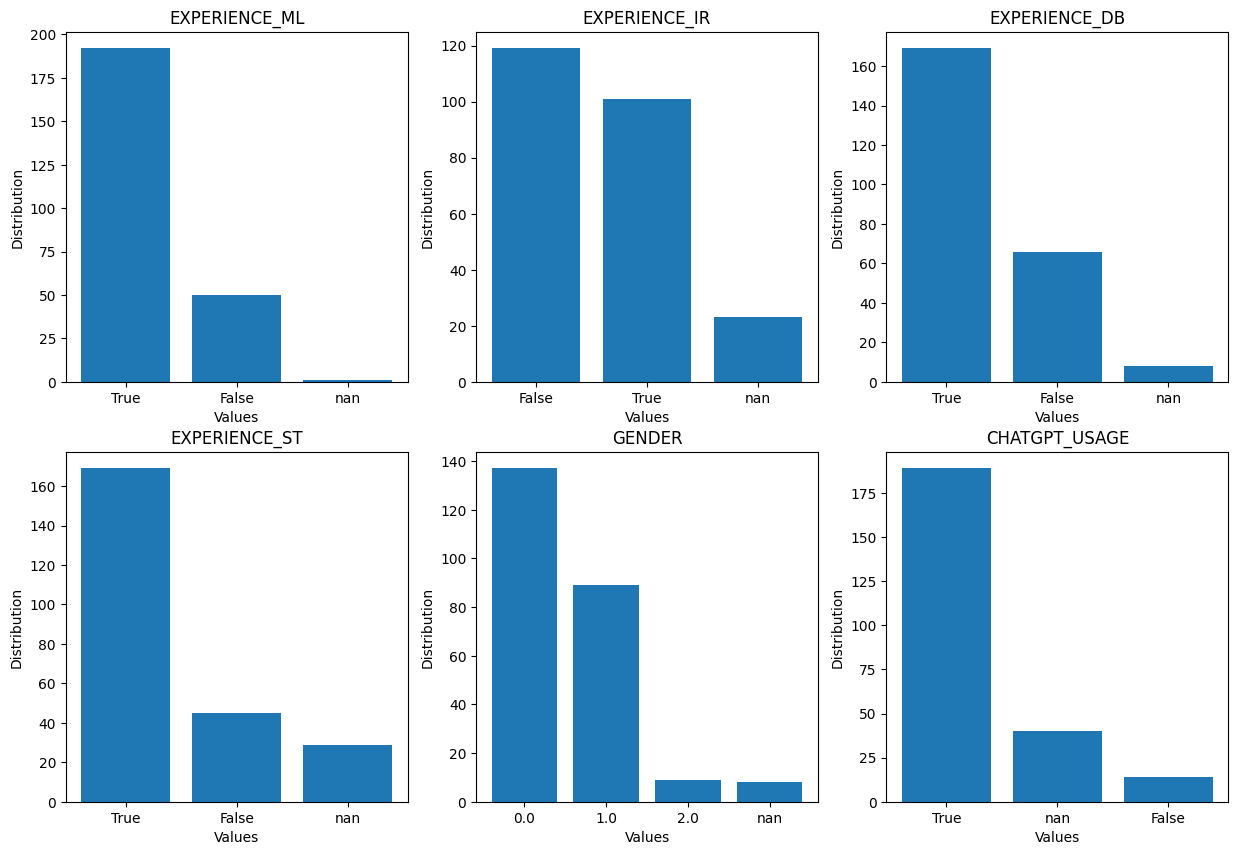

In [1128]:
for col_name in ["experience_ml", "experience_ir", "experience_st", "experience_db", "gender", "chatgpt_usage"]:
    print(f"{col_name.upper()} values:")
    print(raw_data[col_name].unique())

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for idx, col_name in enumerate(
    ["experience_ml", "experience_ir", "experience_db", "experience_st", "gender", "chatgpt_usage"]
):
    row_idx = idx // 3
    col_idx = idx % 3

    value_counts = raw_data[col_name].value_counts(dropna=False)
    value_dist = value_counts / len(raw_data[col_name]) * 100

    ax[row_idx, col_idx].bar(value_counts.index.astype(str), value_counts.values)
    ax[row_idx, col_idx].set_title(col_name.upper())
    ax[row_idx, col_idx].set_xlabel("Values")
    ax[row_idx, col_idx].set_ylabel("Distribution")

plt.show()

Now fill all the nan values for the attributes above by sampling from a distribution that has relative probabilities as of the real value frequencies. (For binary it is going to be Bernouli dist.)

EXPERIENCE_ML:

0


/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/3772039632.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["experience_ml"].loc[raw_data["experience_ml"].isna()] = exp_ml_samples
/var/folders/5j/l7bq8d6913g6mmrl

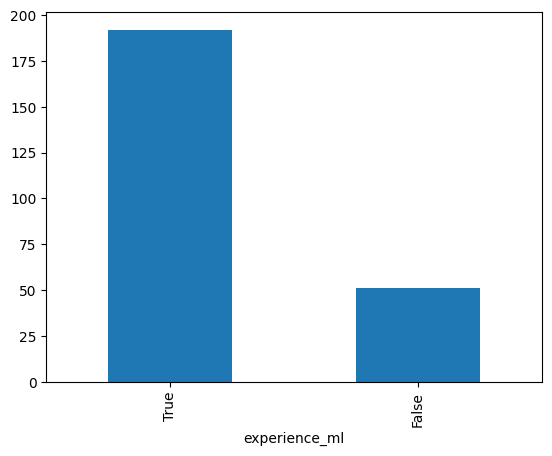

In [1129]:
prob_true_exp_ml = raw_data["experience_ml"].value_counts(normalize=True).get(True, 0)
prob_false_exp_ml = raw_data["experience_ml"].value_counts(normalize=True).get(False, 0)

exp_ml_samples = random.choices(
    [True, False], weights=[prob_true_exp_ml, prob_false_exp_ml], k=raw_data["experience_ml"].isna().sum()
)

raw_data["experience_ml"].loc[raw_data["experience_ml"].isna()] = exp_ml_samples
raw_data["experience_ml"].value_counts().plot(kind="bar")
print(raw_data["experience_ml"].isna().sum())

EXPERIENCE_IR:

/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/1027473954.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["experience_ir"].loc[raw_data["experience_ir"].isna()] = exp_ir_samples
/var/folders/5j/l7bq8d6913g6mmrl

0


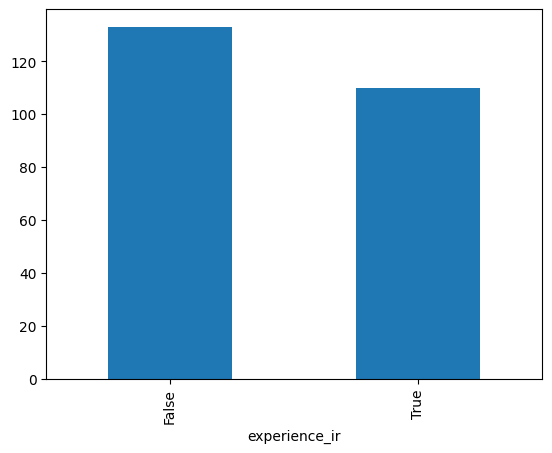

In [1130]:
prob_true_exp_ir = raw_data["experience_ir"].value_counts(normalize=True).get(True, 0)
prob_false_exp_ir = raw_data["experience_ir"].value_counts(normalize=True).get(False, 0)

exp_ir_samples = random.choices(
    [True, False], weights=[prob_true_exp_ir, prob_false_exp_ir], k=raw_data["experience_ir"].isna().sum()
)

raw_data["experience_ir"].loc[raw_data["experience_ir"].isna()] = exp_ir_samples
raw_data["experience_ir"].value_counts().plot(kind="bar")
print(raw_data["experience_ir"].isna().sum())

EXPERIENCE_DB:

/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/3071085736.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["experience_db"].loc[raw_data["experience_db"].isna()] = exp_db_samples
/var/folders/5j/l7bq8d6913g6mmrl

0


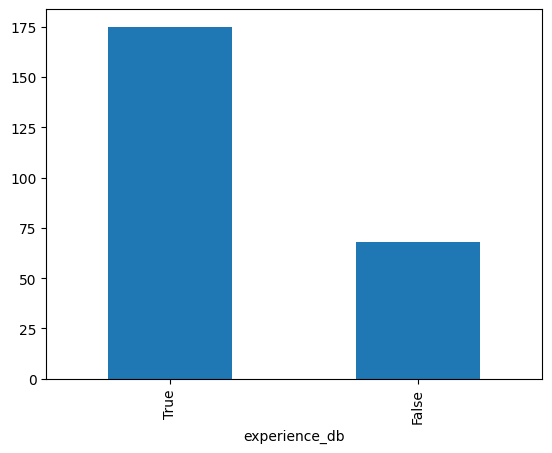

In [1131]:
prob_true_exp_db = raw_data["experience_db"].value_counts(normalize=True).get(True, 0)
prob_false_exp_db = raw_data["experience_db"].value_counts(normalize=True).get(False, 0)

exp_db_samples = random.choices(
    [True, False], weights=[prob_true_exp_db, prob_false_exp_db], k=raw_data["experience_db"].isna().sum()
)

raw_data["experience_db"].loc[raw_data["experience_db"].isna()] = exp_db_samples
raw_data["experience_db"].value_counts().plot(kind="bar")
print(raw_data["experience_db"].isna().sum())

EXPERIENCE_ST:

/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/3071085736.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["experience_db"].loc[raw_data["experience_db"].isna()] = exp_db_samples
/var/folders/5j/l7bq8d6913g6mmrl

0


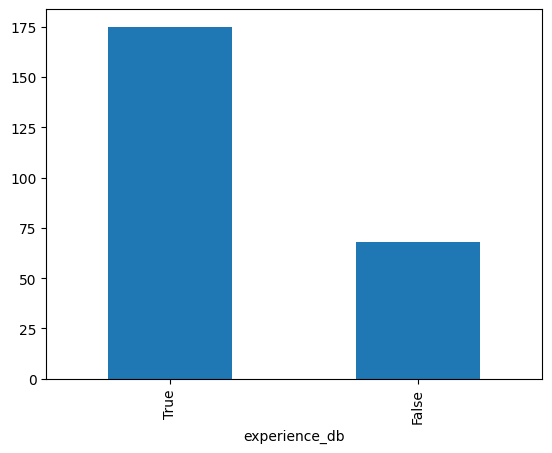

In [1132]:
prob_true_exp_db = raw_data["experience_db"].value_counts(normalize=True).get(True, 0)
prob_false_exp_db = raw_data["experience_db"].value_counts(normalize=True).get(False, 0)

exp_db_samples = random.choices(
    [True, False], weights=[prob_true_exp_db, prob_false_exp_db], k=raw_data["experience_db"].isna().sum()
)

raw_data["experience_db"].loc[raw_data["experience_db"].isna()] = exp_db_samples
raw_data["experience_db"].value_counts().plot(kind="bar")
print(raw_data["experience_db"].isna().sum())

CHATGPT_USAGE:

/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/2195741679.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["experience_st"].loc[raw_data["experience_st"].isna()] = exp_st_samples
/var/folders/5j/l7bq8d6913g6mmrl

0


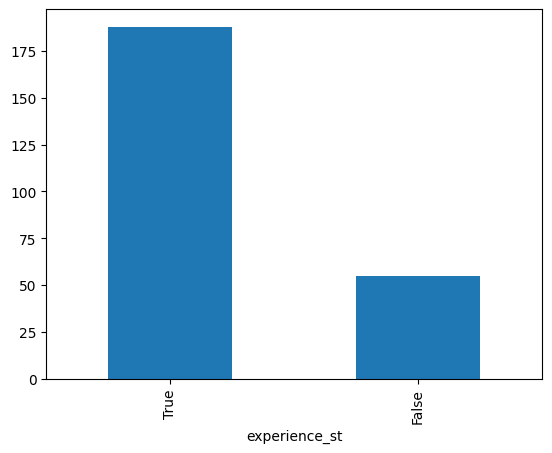

In [1133]:
prob_true_exp_st = raw_data["experience_st"].value_counts(normalize=True).get(True, 0)
prob_false_exp_st = raw_data["experience_st"].value_counts(normalize=True).get(False, 0)

exp_st_samples = random.choices(
    [True, False], weights=[prob_true_exp_st, prob_false_exp_st], k=raw_data["experience_st"].isna().sum()
)

raw_data["experience_st"].loc[raw_data["experience_st"].isna()] = exp_st_samples
raw_data["experience_st"].value_counts().plot(kind="bar")
print(raw_data["experience_st"].isna().sum())

GENDER:

/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/2646667315.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  raw_data["gender"].loc[raw_data["gender"].isna()] = gender_samples
/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn

0


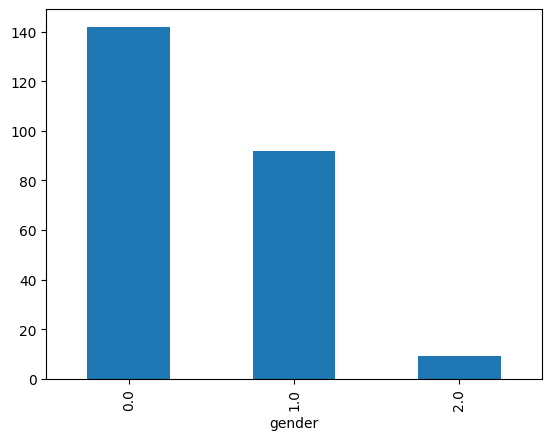

In [1134]:
prob_0 = raw_data["gender"].value_counts(normalize=True).get(0, 0)
prob_1 = raw_data["gender"].value_counts(normalize=True).get(1, 0)
prob_2 = raw_data["gender"].value_counts(normalize=True).get(2, 0)

gender_samples = random.choices([0, 1, 2], weights=[prob_0, prob_1, prob_2], k=raw_data["gender"].isna().sum())

raw_data["gender"].loc[raw_data["gender"].isna()] = gender_samples
raw_data["gender"].value_counts().plot(kind="bar")
print(raw_data["gender"].isna().sum())

Finally, change their datatype.

In [1135]:
new_datatypes = {
    "experience_ml": bool,
    "experience_ir": bool,
    "experience_st": bool,
    "experience_db": bool,
    "gender": np.int8,
    "chatgpt_usage": bool,
}
raw_data = raw_data.astype(new_datatypes)

raw_data.dtypes

programme              object
experience_ml            bool
experience_ir            bool
experience_st            bool
experience_db            bool
gender                   int8
chatgpt_usage            bool
birthday               object
count_students         object
stress_level           object
hours_spend_w_sport    object
bedtime                object
pleasant_thing_1       object
pleasant_thing_2       object
dtype: object

Now treat the following columns (which are class typed str values) from the remaining ones:
- programme
- pleasant_thing_1
- pleasant_thing_2

Lets start with the programme attribute. After the visual inspection of the data, one can distiguish various recurring formations. (As the answer was a free string, not a standardised list.)
The logic is that even tough there are a great variety of the answers there are only a handful of options. In order to make the freely typed answer grouping more efficient the following rules are going to be applied, for the values on which the rule can't be applied, manual mapping (or worst case override to unknown) will be needed.
The rule is the following:
If an answer contains (regardless the small or capital form of the letter) (not complete)
- AI, Aritifical, Intelligence -> Artificial Intelligence (token: 0)
- CS or Computer -> Computer Science (tokes: 1)
- CLS or Computational -> Computational Science (token: 2)
- Finance -> Finance (token: 3)
- Bio or Biology -> Bioinformatics (token: 4)
- Econometrics or Business -> Econometrics (token: 5)


In [1136]:
raw_data["programme"] = raw_data["programme"].str.lower()

combined_mask = (
    r"\b("
    r"ai|artificial|intelligence|"
    r"cs|computer|comp sci|"
    r"cls|computational|"
    r"finance|fintech|"
    r"bio|biology|bioinformatics|biosb|health|biomedical|"
    r"econometrics|business"
    r")\b"
)

not_fitting_programmes = raw_data.loc[
    ~raw_data["programme"].str.contains(combined_mask, regex=True, na=False), "programme"
]
print(not_fitting_programmes)

ai_mask = r"\b(ai|artificial|intelligence)\b"
cs_mask = r"\b(cs|computer|comp sci)\b"
cls_mask = r"\b(cls|computational)\b"
fin_mask = r"\b(finance|fintech)\b"
bio_mask = r"\b(bio|biology|bioinformatics|biosb|health|biomedical)\b"
eco_mask = r"\b(econometrics|business)\b"

masks = [ai_mask, cs_mask, cls_mask, fin_mask, bio_mask, eco_mask]

for idx, mask in enumerate(masks):
    raw_data.loc[raw_data["programme"].str.contains(mask, regex=True, na=False), "programme"] = str(idx)

12                                   npn
39             human language technology
50                             security 
115                            security 
119                          mathematics
123       human language technology (rm)
147                 big-data engineering
152                                  eor
160           humanities research master
172                               master
212                             green it
213                                   ba
236                big data engineering 
237    software engineering and green it
Name: programme, dtype: object


/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/4119765894.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  not_fitting_programmes =  raw_data.loc[~raw_data["programme"].str.contains(combined_mask, regex=True, na=False), "programme"]
/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/4119765894.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  raw_data.loc[raw_data["programme"].str.contains(mask, regex=True, na=False), "programme"] = str(idx)
/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/4119765894.py:27: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  raw_data.loc[raw_data["programme"].str.contains(mask, regex=True, na=False), "programme"] = str(idx)
/var/folders/5j/l7

Question: should we further create IT group and put security and green it etc. there or create an "other" group for the rest.
Temporary I am going create a container token: 6 for them.

In [1137]:
temp_mask = r"\b(0|1|2|3|4|5)\b"
raw_data.loc[~raw_data["programme"].str.contains(temp_mask, regex=True, na=False), "programme"] = str(6)

raw_data["programme"] = raw_data["programme"].astype(np.int8)
print(raw_data["programme"].value_counts(dropna=False))

programme
0    100
1     44
5     39
4     22
2     17
6     14
3      7
Name: count, dtype: int64


/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/1899119615.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  raw_data.loc[~raw_data["programme"].str.contains(temp_mask, regex=True, na=False), "programme"] = str(6)


Lets check the distribution of the various master programmes.

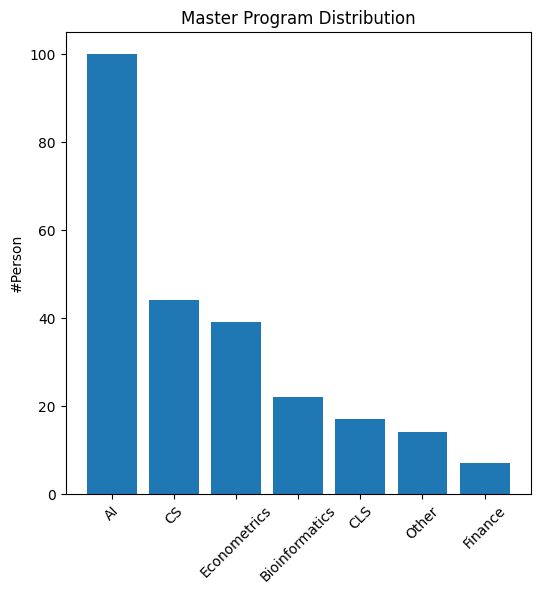

In [1138]:
back_mapping = {0: "AI", 1: "CS", 2: "CLS", 3: "Finance", 4: "Bioinformatics", 5: "Econometrics", 6: "Other"}

programmes = raw_data["programme"].copy()
programmes = programmes.map(back_mapping)

plt.figure(figsize=(6, 6))

plt.bar(programmes.value_counts(dropna=False).index, programmes.value_counts().values)
plt.title("Master Program Distribution")
plt.xticks(rotation=45)
plt.ylabel("#Person")

plt.show()

Next lets clean the student counts attribute. First check how many of the sample can be simply interpreted as a number.

In [1139]:
not_numeric = pd.to_numeric(raw_data["count_students"], errors="coerce").notna()
print(np.sum(~np.array(not_numeric)))

6


As it turned out, there are 6 values that needs to be addressed manually

In [1140]:
print(raw_data.loc[~pd.to_numeric(raw_data["count_students"], errors="coerce").notna(), "count_students"])

28        180-200
32         20*5*5
116    approx 300
132       300ish?
137    Around 200
149           Idk
Name: count_students, dtype: object


Lets override the ones that make sense. And replace the ones that can't be interpreted.

In [1141]:
raw_data.loc[28, "count_students"] = 190
raw_data.loc[32, "count_students"] = 500
raw_data.loc[116, "count_students"] = 300
raw_data.loc[132, "count_students"] = 300
raw_data.loc[137, "count_students"] = 200

raw_data["count_students"] = raw_data["count_students"].apply(
    lambda x: max(min(int(x), 600), 50) if isinstance(x, (int, float)) else x
)
raw_data["count_students"] = pd.to_numeric(raw_data["count_students"], errors="coerce").astype("Int64")

print(raw_data["count_students"].isna().sum())

print(raw_data["count_students"].mean())
raw_data["count_students"] = raw_data["count_students"].fillna(int(raw_data["count_students"].mean()))
raw_data["count_students"] = raw_data["count_students"].astype(np.int16)
print(raw_data["count_students"].isna().sum())
print(raw_data.dtypes)

1
343.77272727272725
0
programme                int8
experience_ml            bool
experience_ir            bool
experience_st            bool
experience_db            bool
gender                   int8
chatgpt_usage            bool
birthday               object
count_students          int16
stress_level           object
hours_spend_w_sport    object
bedtime                object
pleasant_thing_1       object
pleasant_thing_2       object
dtype: object


The same logic can be applied to the stress level and the hours spent with sport per week.

In [1142]:
not_numeric = pd.to_numeric(raw_data["stress_level"], errors="coerce").notna()
print(np.sum(~np.array(not_numeric)))

print(raw_data.loc[~pd.to_numeric(raw_data["stress_level"], errors="coerce").notna(), "stress_level"])

raw_data.loc[88, "stress_level"] = 9000
raw_data.loc[185, "stress_level"] = 22

raw_data["stress_level"] = raw_data["stress_level"].apply(
    lambda x: max(min(float(x), 100), 0) if isinstance(x, (int, float)) else x
)
raw_data["stress_level"] = pd.to_numeric(raw_data["stress_level"], errors="coerce").astype(np.float64)
print(raw_data["stress_level"].mean())
raw_data["stress_level"] = raw_data["stress_level"].fillna(float(raw_data["stress_level"].mean()))
raw_data["stress_level"] = raw_data["stress_level"].astype(np.float64)
print(raw_data["stress_level"].isna().sum())
print(raw_data.dtypes)

4
88     Over 9000
115           π©
185      Now? 22
202          NaN
Name: stress_level, dtype: object
47.236224066390044
0
programme                 int8
experience_ml             bool
experience_ir             bool
experience_st             bool
experience_db             bool
gender                    int8
chatgpt_usage             bool
birthday                object
count_students           int16
stress_level           float64
hours_spend_w_sport     object
bedtime                 object
pleasant_thing_1        object
pleasant_thing_2        object
dtype: object


6
28           4-5
136           2h
146         0😭😭😭
150         zero
161          3-4
196    4.5 hours
Name: hours_spend_w_sport, dtype: object
0
programme                 int8
experience_ml             bool
experience_ir             bool
experience_st             bool
experience_db             bool
gender                    int8
chatgpt_usage             bool
birthday                object
count_students           int16
stress_level           float64
hours_spend_w_sport    float64
bedtime                 object
pleasant_thing_1        object
pleasant_thing_2        object
dtype: object


<Axes: >

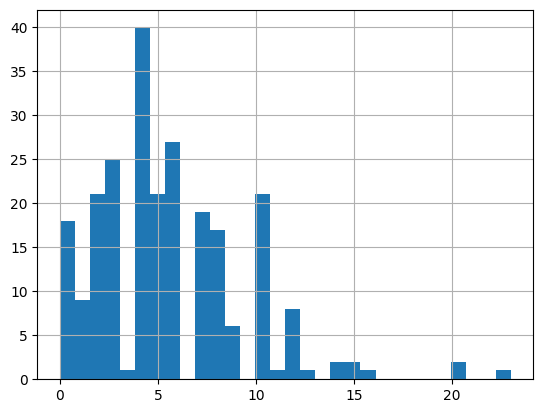

In [1143]:
not_numeric = pd.to_numeric(raw_data["hours_spend_w_sport"], errors="coerce").notna()
print(np.sum(~np.array(not_numeric)))

print(raw_data.loc[~pd.to_numeric(raw_data["hours_spend_w_sport"], errors="coerce").notna(), "hours_spend_w_sport"])

raw_data.loc[28, "hours_spend_w_sport"] = 4.5
raw_data.loc[136, "hours_spend_w_sport"] = 2
raw_data.loc[146, "hours_spend_w_sport"] = 0
raw_data.loc[150, "hours_spend_w_sport"] = 0
raw_data.loc[161, "hours_spend_w_sport"] = 3.5
raw_data.loc[196, "hours_spend_w_sport"] = 4.5

raw_data["hours_spend_w_sport"] = raw_data["hours_spend_w_sport"].astype(np.float64)
print(raw_data["hours_spend_w_sport"].isna().sum())
print(raw_data.dtypes)

upper_threshold = raw_data["hours_spend_w_sport"].quantile(0.99)
lower_threshold = 0

raw_data.loc[raw_data["hours_spend_w_sport"] < lower_threshold, "hours_spend_w_sport"] = np.nan
raw_data.loc[raw_data["hours_spend_w_sport"] > upper_threshold, "hours_spend_w_sport"] = np.nan

mean_hours_spent_w_sport = raw_data["hours_spend_w_sport"].mean()

raw_data["hours_spend_w_sport"] = raw_data["hours_spend_w_sport"].fillna(mean_hours_spent_w_sport)

raw_data["hours_spend_w_sport"].hist(bins=30)

Now lets clean the birthday and bedtime attributes. Starting with birthday, try to convert random formats to datetime variable.

In [1144]:
def convert_time_to_datetime(x):
    try:
        return parse(x, dayfirst=True, fuzzy=True)
    except:
        return x


raw_data["birthday"] = raw_data["birthday"].apply(convert_time_to_datetime)
print(raw_data["birthday"])
print(raw_data["birthday"].isna().sum())

0                        1888-01-01 00:00:00
1                        2002-01-31 00:00:00
2                        2025-09-14 00:00:00
3                        2003-10-17 00:00:00
4                        2000-04-19 00:00:00
5                                   Tomorrow
6                        1999-10-25 00:00:00
7                        2025-04-01 00:00:00
8                        2001-01-29 00:00:00
9                                   01082000
10                       1999-10-19 00:00:00
11                       1999-01-01 00:00:00
12                                  01012000
13                       2001-06-15 00:00:00
14                       2025-04-01 00:00:00
15                       2001-02-27 00:00:00
16                       1982-05-10 00:00:00
17                       1998-12-16 00:00:00
18                       2002-06-23 00:00:00
19                       2000-08-10 00:00:00
20                       2003-12-30 00:00:00
21                       2025-08-11 00:00:00
22        

Check the values that couldn't be converted automatically.

5     NaT
22    NaT
52    NaT
56    NaT
81    NaT
86    NaT
90    NaT
91    NaT
101   NaT
118   NaT
131   NaT
136   NaT
150   NaT
151   NaT
168   NaT
203   NaT
236   NaT
Name: birthday, dtype: datetime64[ns]


/var/folders/5j/l7bq8d6913g6mmrlqytjzbbm0000gn/T/ipykernel_15036/3650299004.py:17: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  threshold_date_upper = pd.to_datetime("31-12-2004")


<Axes: xlabel='birthday'>

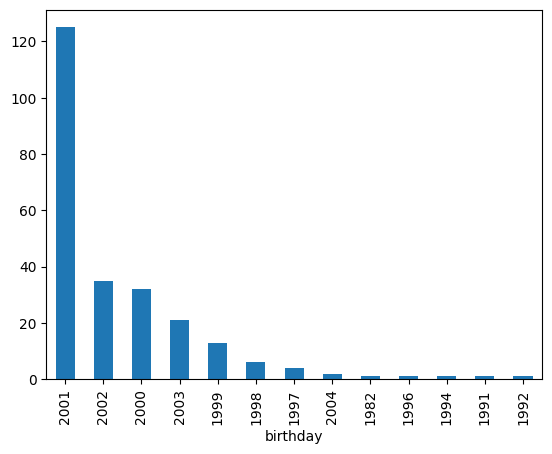

In [1145]:
# print(raw_data.loc[~pd.to_datetime(raw_data["birthday"], errors="coerce").notna(), "birthday"])

raw_data.loc[9, "birthday"] = "01-08-2000"
raw_data.loc[12, "birthday"] = "01-01-2000"
raw_data.loc[31, "birthday"] = "29-07-2000"
raw_data.loc[76, "birthday"] = "08-03-1998"
raw_data.loc[107, "birthday"] = "05-08-2000"
raw_data.loc[169, "birthday"] = "17-08-2001"
raw_data.loc[221, "birthday"] = "16-06-2001"
raw_data.loc[228, "birthday"] = "24-01"

raw_data["birthday"] = pd.to_datetime(raw_data["birthday"].apply(convert_time_to_datetime), errors="coerce")

print(raw_data.loc[~pd.to_datetime(raw_data["birthday"], errors="coerce").notna(), "birthday"])

threshold_date_lower = pd.to_datetime("01-01-1980")
threshold_date_upper = pd.to_datetime("31-12-2004")

raw_data.loc[raw_data["birthday"] < threshold_date_lower, "birthday"] = np.nan
raw_data.loc[raw_data["birthday"] > threshold_date_upper, "birthday"] = np.nan

mean_birthday = raw_data["birthday"].dropna().astype(np.int64).mean()
mean_birthday = pd.to_datetime(mean_birthday)
raw_data["birthday"] = raw_data["birthday"].fillna(mean_birthday)
raw_data["birthday"] = raw_data["birthday"].dt.year

raw_data["birthday"] = raw_data["birthday"].astype(np.int16)

# print(raw_data["birthday"].isna().sum())
# print(raw_data["birthday"].head())
raw_data["birthday"].value_counts().plot(kind="bar")

Now the same process can be done for bed time.

In [1146]:
# raw_data["bedtime"] = raw_data["bedtime"].apply(convert_time_to_datetime)
# print(np.sum(np.array(~pd.to_datetime(raw_data["bedtime"], errors="coerce").notna())))
# print(raw_data.loc[~pd.to_datetime(raw_data["bedtime"], errors="coerce").notna(), "bedtime"])

raw_data.loc[9, "bedtime"] = "00:00"
raw_data.loc[26, "bedtime"] = "00:30"
raw_data.loc[54, "bedtime"] = "23:00"
raw_data.loc[58, "bedtime"] = "00:30"
raw_data.loc[114, "bedtime"] = "00:00"
raw_data.loc[150, "bedtime"] = "00:00"
raw_data.loc[152, "bedtime"] = "23:30"
raw_data.loc[196, "bedtime"] = "00:15"

raw_data["bedtime"] = raw_data["bedtime"].apply(convert_time_to_datetime)
print(np.sum(np.array(~pd.to_datetime(raw_data["bedtime"], errors="coerce").notna())))
raw_data["bedtime"] = pd.to_datetime(raw_data["bedtime"], errors="coerce")

raw_data["bedtime"] = raw_data["bedtime"].where(
    (raw_data["bedtime"].dt.hour >= 20) | (raw_data["bedtime"].dt.hour <= 5), np.nan
)

print(raw_data["bedtime"].isna().sum())

valid_times = raw_data["bedtime"].dropna()
minutes = valid_times.dt.hour * 60 + valid_times.dt.minute
angles = 2 * np.pi * minutes / (24 * 60)
mean_angle = np.arctan2(np.sin(angles).mean(), np.cos(angles).mean())
mean_minutes = (mean_angle % (2 * np.pi)) * (24 * 60) / (2 * np.pi)
mean_hour = int(mean_minutes // 60)
mean_minute = int(round(mean_minutes % 60))

mean_time = f"{mean_hour}:{mean_minute}".zfill(5)
print(mean_time)

print(mean_time)
raw_data["bedtime"] = raw_data["bedtime"].fillna(mean_time)
raw_data["bedtime"] = pd.to_datetime(raw_data["bedtime"], errors="coerce")

print(raw_data["bedtime"].isna().sum())

0
17
00:32
00:32
0


Convert the bedtime into the minutes passed since 8 pm.

0      240
1      272
2      270
3      180
4      240
5      540
6      272
7      240
8      272
9      240
10     180
11     240
12     225
13     272
14     240
15     360
16     240
17     240
18     196
19     240
20     300
21     240
22     300
23     272
24     210
25     270
26     270
27     240
28     300
29     240
30     272
31     237
32     540
33     240
34     210
35     480
36     150
37     285
38     270
39     330
40     270
41     210
42     240
43     220
44     240
45     360
46     300
47     360
48     239
49     240
50     240
51     300
52     480
53     360
54     180
55     240
56     480
57     240
58     270
59     240
60     300
61     300
62     272
63     210
64     240
65     240
66     240
67     270
68     180
69     240
70     270
71     180
72     180
73     240
74     272
75     240
76     180
77     235
78     225
79     360
80     330
81     270
82     240
83     300
84     240
85     272
86     240
87     210
88     540
89     240
90     360

<Axes: >

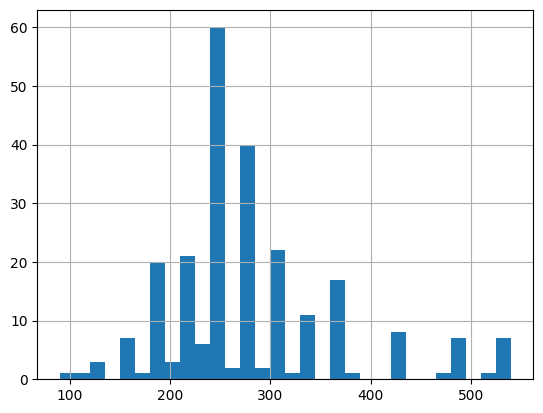

In [1147]:
def convert_minutes_passed_since_8(x):
    if x.hour < 20:
        return 4 * 60 + x.hour * 60 + x.minute
    return x.hour * 60 + x.minute - 20 * 60


raw_data["bedtime"] = raw_data["bedtime"].apply(convert_minutes_passed_since_8)
print(raw_data["bedtime"])

raw_data["bedtime"] = raw_data["bedtime"].astype(np.int16)

raw_data["bedtime"].hist(bins=30)

Finally, lets create categories for the 'pleasant_thing_1' attribute:

Items not matching any category:
2                                        zonnetje
4                                               -
21                                               
47                                   ajax winning
52                                          happy
54                                     az winning
58                        praying 5 times on time
62                                     a good day
69                                     happiness 
70                      doing things i want to do
85                      not having looking for x 
94                                            NaN
99                                  feeling good 
104                                         money
112                     i take the adhd medicine 
119                                        you :)
124                                         peace
131                                      grounded
133                                         money
140              

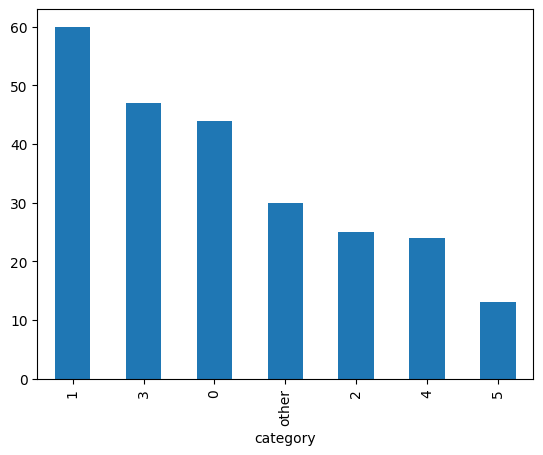

In [1148]:
raw_data["pleasant_thing_1"] = raw_data["pleasant_thing_1"].str.lower()

# Define masks for each category
food_mask = r"food|chocolate|pizza|coffee|bubble tea|beer|meal|delicious|burrata|eating|breakfast|cola|banana|baking|alcohol|potato"
nature_mask = r"sun|sunny|sunshine|weather|rain|outside|warm|mild|nature|outdoors"
social_mask = r"friend|friends|hanging|boyfriend|socializing|people|smile|love|cats|doggo|buddies|gezelligheid|boardgames|family|mama|spending time with|socialising|good talks"
activity_mask = r"sport|gym|yoga|workout|running|exercise|dance|reading|motorcycle|videogames|snorkeling|travel|routine|sleeping|sleep|sex|fieldtrip|hockey|free time|energized|booking tickets|go out|cooking"
academic_mask = r"work|productivity|passing|courses|grades|grade|studying|assignments|lectures|exams|achievements|class|deadlines|achivements|productive"
lazy_mask = r"not having edda exam|drugs|nothing|no school|weed|no responsibilities|not going to uni|brazzers|no course|not having to wake up early|not wake up tired"

# Create a new column to store the categories
raw_data["category"] = "other"  # Default category

# Apply each mask in order
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(food_mask, regex=True, na=False), "category"] = "0"
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(nature_mask, regex=True, na=False), "category"] = "1"
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(social_mask, regex=True, na=False), "category"] = "2"
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(activity_mask, regex=True, na=False), "category"] = "3"
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(academic_mask, regex=True, na=False), "category"] = "4"
raw_data.loc[raw_data["pleasant_thing_1"].str.contains(lazy_mask, regex=True, na=False), "category"] = "5"

# Items that don't fit any category
not_fitting_items = raw_data.loc[raw_data["category"] == "other", "pleasant_thing_1"]
print("Items not matching any category:")
print(not_fitting_items)

# Plot the distribution
raw_data["category"].value_counts().plot(kind="bar")

raw_data.loc[raw_data["category"] == "other", "category"] = "6"
raw_data["pleasant_thing_1"] = raw_data["category"]
raw_data.drop("category", axis=1, inplace=True)
raw_data["pleasant_thing_1"] = raw_data["pleasant_thing_1"].astype(np.int8)

Finally check the columns, their distribution and the datatypes.

In [1149]:
print(raw_data.dtypes)

programme                 int8
experience_ml             bool
experience_ir             bool
experience_st             bool
experience_db             bool
gender                    int8
chatgpt_usage             bool
birthday                 int16
count_students           int16
stress_level           float64
hours_spend_w_sport    float64
bedtime                  int16
pleasant_thing_1          int8
pleasant_thing_2        object
dtype: object


Text(0.5, 1.0, 'Programme')

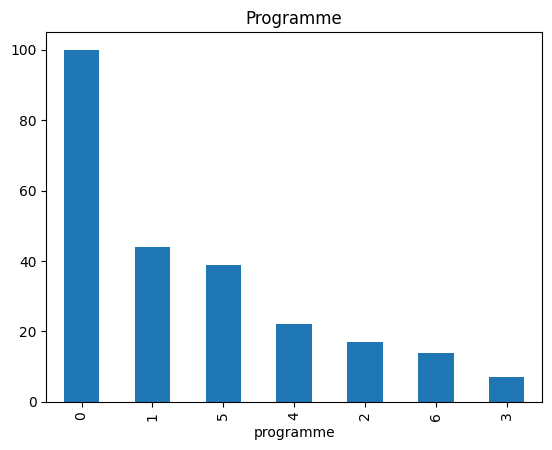

In [1150]:
raw_data["programme"].value_counts().plot(kind="bar").set_title("Programme")

Text(0.5, 1.0, 'Experience ML')

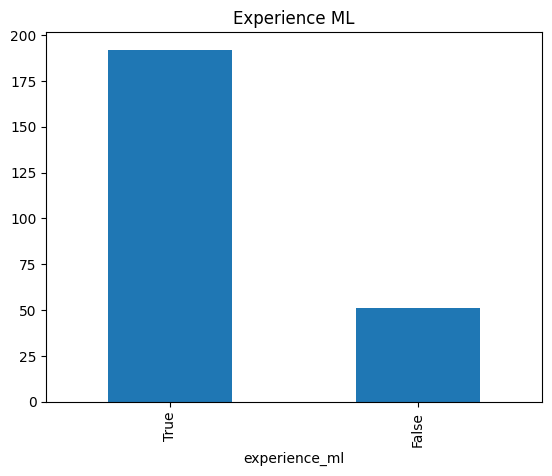

In [1151]:
raw_data["experience_ml"].value_counts().plot(kind="bar").set_title("Experience ML")

Text(0.5, 1.0, 'Experience IR')

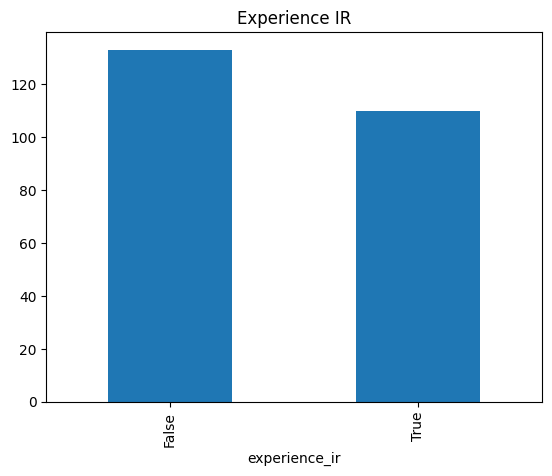

In [1152]:
raw_data["experience_ir"].value_counts().plot(kind="bar").set_title("Experience IR")

Text(0.5, 1.0, 'Experience DB')

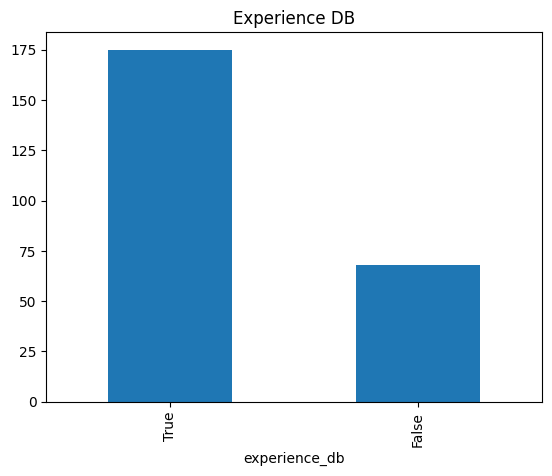

In [1153]:
raw_data["experience_db"].value_counts().plot(kind="bar").set_title("Experience DB")

Text(0.5, 1.0, 'Experience ST')

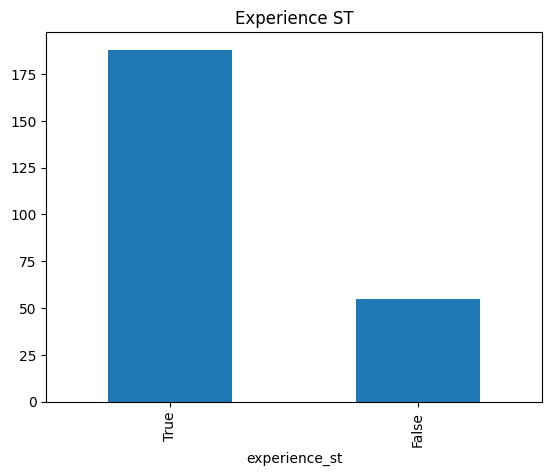

In [1154]:
raw_data["experience_st"].value_counts().plot(kind="bar").set_title("Experience ST")

Text(0.5, 1.0, 'Gender')

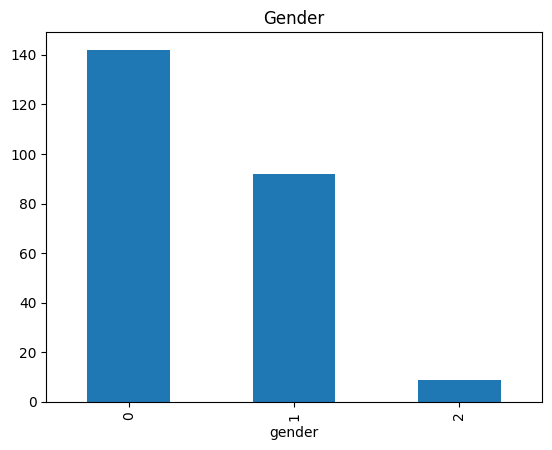

In [1155]:
raw_data["gender"].value_counts().plot(kind="bar").set_title("Gender")

Text(0.5, 1.0, 'ChatGPT Usage')

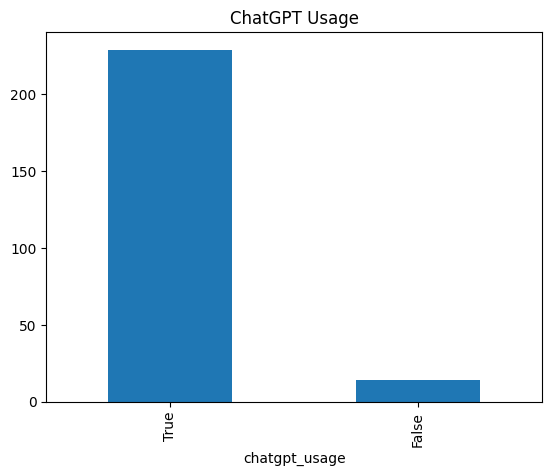

In [1156]:
raw_data["chatgpt_usage"].value_counts().plot(kind="bar").set_title("ChatGPT Usage")

Text(0.5, 1.0, 'Birthday')

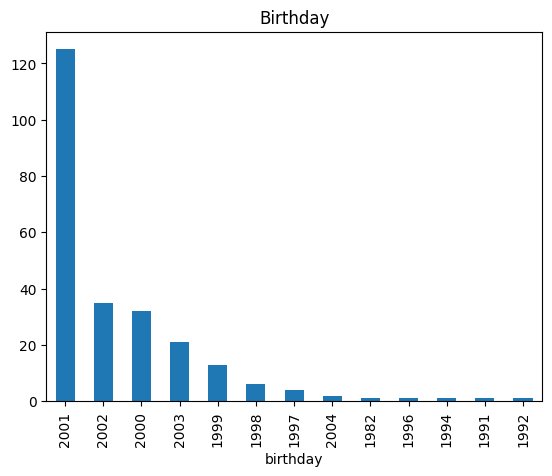

In [1157]:
raw_data["birthday"].value_counts().plot(kind="bar").set_title("Birthday")

Text(0.5, 1.0, 'Student Count')

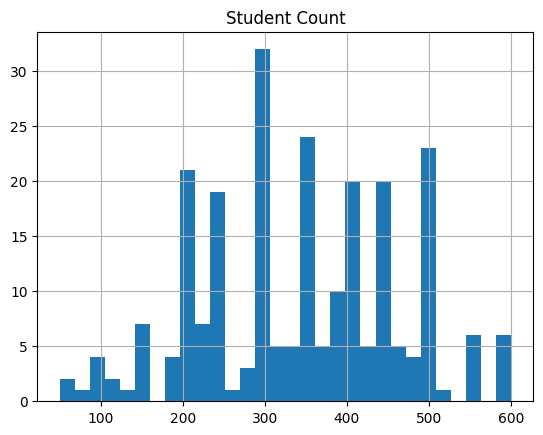

In [1158]:
raw_data["count_students"].hist(bins=30).set_title("Student Count")

Text(0.5, 1.0, 'Stress Level')

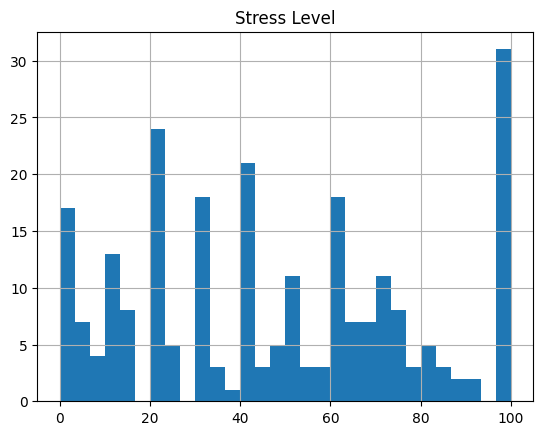

In [1159]:
raw_data["stress_level"].hist(bins=30).set_title("Stress Level")

Text(0.5, 1.0, 'Hours Spent with Sport per Week')

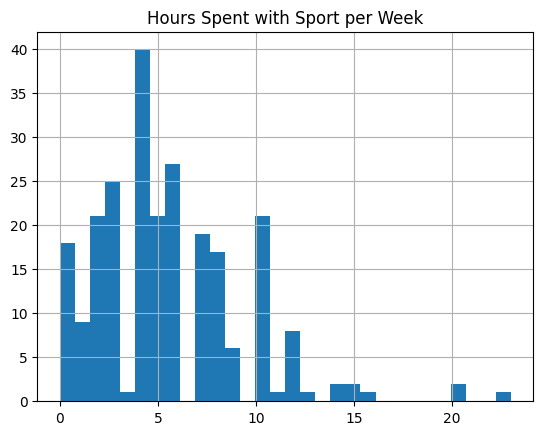

In [1160]:
raw_data["hours_spend_w_sport"].hist(bins=30).set_title("Hours Spent with Sport per Week")

Text(0.5, 1.0, 'Bedtime')

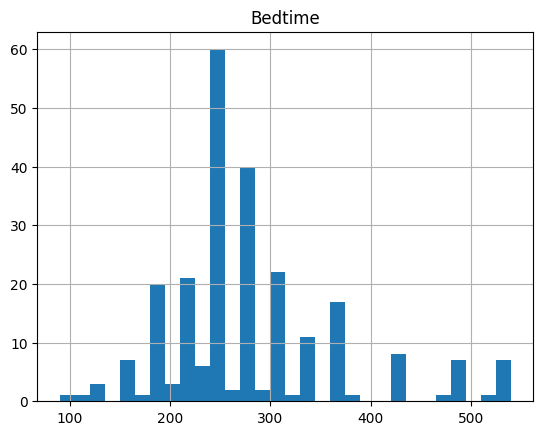

In [1161]:
raw_data["bedtime"].hist(bins=30).set_title("Bedtime")

Text(0.5, 1.0, 'Pleasant Thing 1')

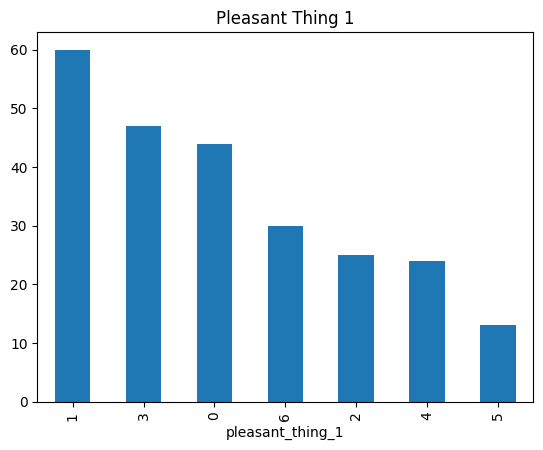

In [1162]:
raw_data["pleasant_thing_1"].value_counts().plot(kind="bar").set_title("Pleasant Thing 1")